# Parameter Estimation
First get handle to example model file:

In [5]:
%matplotlib inline
import os,glob

for i in glob.glob('*.cps'):
    kholodenko_model= os.path.abspath(i)
    
print kholodenko_model
print os.path.isfile(kholodenko_model)

/home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/Kholodenko.cps
True


Now simulate some synthetic data for sake of running an example:

In [65]:
import PyCoTools,pandas
report= 'parameter_estimation_synthetic_data.txt'
TC=PyCoTools.pycopi.TimeCourse(kholodenko_model,Start=0,End=1000,Intervals=1000,StepSize=1,
                            ReportName = report)

## validate that its worked
print pandas.read_csv(TC.kwargs['ReportName'],sep='\t').head()

## Give fake data a meaningful name
data1 = TC.kwargs['ReportName']

   Time       Mek1-PP        Erk2      Mos   Erk2-P  Erk2-PP     Mos-P  \
0     0  2.000000e+01  280.000000  90.0000   10.000  10.0000  10.00000   
1     1  9.104570e-07    0.012525  90.0479  289.863  10.1249   9.95215   
2     2  9.060800e-07    0.028488  90.0955  289.847  10.1247   9.90453   
3     3  9.017240e-07    0.044451  90.1429  289.831  10.1244   9.85713   
4     4  8.973890e-07    0.060414  90.1900  289.815  10.1241   9.80995   

         Mek1   Mek1-P  
0  280.000000   10.000  
1    0.045896  309.954  
2    0.046117  309.954  
3    0.046340  309.954  
4    0.046564  309.953  


Note that it is completely necessary to have column headings in a data file that exactly match a model variable. Independant variables can be mapped easily by appending the suffic `'_indep'` to the variable. If you had two data sets that stimulated cell cultures at different concentrations for example, you could have `stimulation_indep` as a column heading in both with each containing the amount of stimulant that was used in the experiment. 

# Setup and run single parameter estimation 
Now we're ready to setup and run a parameter estimation

In [13]:
import PyCoTools, os
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1)

## default method is GeneticAlgorithm
print PE.kwargs['Method']

geneticalgorithm


To change the optimization algorithm use the Method kwarg


In [14]:
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1,
                                        Method='HookJeeves')

AssertionError: HookJeeves is not a copasi PE Method. Choose one of: ['CurrentSolutionStatistics', 'DifferentialEvolution', 'EvolutionaryStrategySR', 'EvolutionaryProgram', 'HookeJeeves', 'LevenbergMarquardt', 'NelderMead', 'ParticleSwarm', 'Praxis', 'RandomSearch', 'ScatterSearch', 'SimulatedAnnealing', 'SteepestDescent', 'TruncatedNewton', 'GeneticAlgorithm', 'GeneticAlgorithmSR']

If you spell an algorithm wrong you'll be presented with a list of valid stings for the Method parameter. Lets try again

In [17]:
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1,
                                        Method='HookeJeeves')

## validate (methods are converted into lowercase strings)
PE.kwargs['Method']

'hookejeeves'

All algorithm specific parameters should be defined here, along with the instantiation of the ParameterEstimation class

In [23]:
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1,
                                        Method='HookeJeeves',
                                        IterationLimit = 100,
                                        Tolerance = 1e-10)

## check
print 'Tolerance = ',PE.kwargs['Tolerance']
print 'IterationLimit =', PE.kwargs['IterationLimit']

Tolerance =  1e-10
IterationLimit = 100


Now use the `write_item_template` method to create a parameter estimation configuration file:

In [26]:
PE.write_item_template()

/home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/PEConfigFile.xlsx


The path to the config file is stored in the `ConfigFilename` kwarg and can be provided on instantiation if desired. Here we use the default:

In [29]:
print PE.kwargs['ConfigFilename']

## check that the config filename exists
print os.path.isfile(PE.kwargs['ConfigFilename'])

/home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/PEConfigFile.xlsx
True


A parameter estimation configuration file has 7 columns but the last three are not meant to be modified in any way. Each row corresponds to a parameter in your model and by default all kinetic parameters (local and global) and initial concentration parameters are included in the configuration. To exclude a parameter from the estimation simply delete the row corresponding to the parameter you wish to remove. Also, specify the estimation boundaries for each parameter and optionally the starting value. It is common to randomize the start values however and so the start values column is rarely used. If you would like to use the configuration file as to specify start values then you must set the `UseTemplateStartValues` option to `'true'`. 

After modification, save and close the file. In the example, no modifications we're made and so all kinetic and initial concentration parameters are estimated. 

Now use the `set_up()` and `run()` methods. 

In [30]:
PE.set_up()

Open the model and check the parameter estimation task (optionally run the next cell). The ParameterEstimation class has performed the configuration that used to have to do manually. 

In [32]:
import os
os.system('CopasiUI {}'.format(kholodenko_model))
##  remember to close the model before continuing

0

The `Run()` method will run the copasi file using `CopasiSE` behind the scenes (provided that an environment variable called `CopasiSE` is set up and pointing to the location of `CopasiSE` on disk. 

In [33]:
PE.run() # will take some time

<PyCoTools.pycopi.Run instance at 0x7f127594c440>

The `run()` method should take a bit of time and the output will be the parameter estimation data as the algorithm progresses from first to last function evaluation. This means that the best parameters are at the end. Lets take a look

   [Mek1-PP]_0  [Erk2]_0   [Mos]_0  [Erk2-P]_0  [Erk2-PP]_0  [Mos-P]_0  \
0     0.000002   7394.53  0.000146     912.440      189.637   101.2530   
1     0.000002   7394.53  0.000146     912.440      189.637   101.2530   
2     0.000001   7394.53  0.000146     912.440      189.637   101.2530   
3     0.000001   7394.53  0.000146     912.440      189.637   101.2530   
4     0.000001   5915.62  0.000117     729.952      151.709    81.0021   

   [Mek1]_0  [Mek1-P]_0  (phosphorylation of MAPKK).KK3  \
0   26857.0    0.183076                        0.000033   
1   26857.0    0.146460                        0.000033   
2   26857.0    0.219691                        0.000033   
3   26857.0    0.219691                        0.000040   
4   21485.6    0.219691                        0.000046   

   (MAPKKK activation).K1  \
0                0.000004   
1                0.000004   
2                0.000004   
3                0.000004   
4                0.000003   

                         

/home/b3053674/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


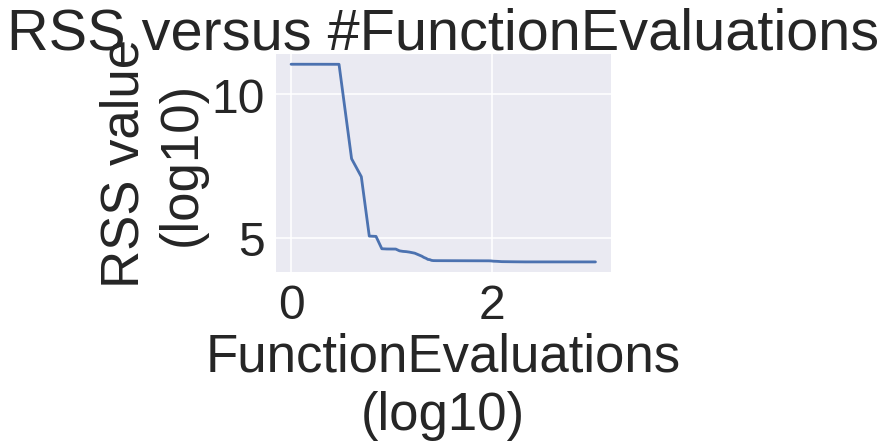

In [42]:
import pandas
import matplotlib.pyplot as plt
import numpy
## lets take a look at the parameter estimation results
pe_data= pandas.read_csv(PE.kwargs['ReportName'],sep='\t') 

## top 5 function evaluations
print pe_data.head()

##last 5 function evaluations
print pe_data.tail()

## visualise the best value over function evaluations
rss_string='TaskList[Parameter Estimation].(Problem)Parameter Estimation.Best Value'
plt.figure()
plt.plot(numpy.log10(pe_data.index),numpy.log10(pe_data[rss_string]))
plt.title('RSS versus #FunctionEvaluations')
plt.xlabel('FunctionEvaluations\n(log10)')
plt.ylabel('RSS value\n(log10)')

## Multiple Data Files
PyCoTools can easily handle multiple data files by giving `ParameterEsimation` a list of data file paths. Lets simulate some more data.

First change the value of a parameter so both sets of simulated data are not identical:

In [59]:
import PyCoTools,os
## Original value of Mek1-PP at time 0 is 10. 
GMQ=PyCoTools.pycopi.GetModelQuantities(kholodenko_model)
print GMQ.get_metabolites()['Mek1-PP']

#Use InsertParameters to change it to 20
I=PyCoTools.pycopi.InsertParameters(kholodenko_model,ParameterDict={'Mek1-PP':20})
GMQ=PyCoTools.pycopi.GetModelQuantities(kholodenko_model)
print GMQ.get_metabolites()['Mek1-PP']



{'concentration': 20.0, 'compartment': 'uVol', 'particle_numbers': '1.204428358e+16'}
{'concentration': 20.0, 'compartment': 'uVol', 'particle_numbers': '1.204428358e+16'}


0

And Simulate some data:

In [57]:
import PyCoTools,pandas
report= 'parameter_estimation_synthetic_data2.txt'
TC=PyCoTools.pycopi.TimeCourse(kholodenko_model,
                               End=1000,
                               Intervals=1000,
                               StepSize=1,
                               ReportName = report)

## validate that its worked
print pandas.read_csv(TC.kwargs['ReportName'],sep='\t').head()

## Give fake data a meaningful name
data2 = TC.kwargs['ReportName']

   Time       Mek1-PP        Erk2      Mos   Erk2-P  Erk2-PP     Mos-P  \
0     0  2.000000e+01  280.000000  90.0000   10.000  10.0000  10.00000   
1     1  9.104570e-07    0.012525  90.0479  289.863  10.1249   9.95215   
2     2  9.060800e-07    0.028488  90.0955  289.847  10.1247   9.90453   
3     3  9.017240e-07    0.044451  90.1429  289.831  10.1244   9.85713   
4     4  8.973890e-07    0.060414  90.1900  289.815  10.1241   9.80995   

         Mek1   Mek1-P  
0  280.000000   10.000  
1    0.045896  309.954  
2    0.046117  309.954  
3    0.046340  309.954  
4    0.046564  309.953  


Now setup a parameter estimation like before and run. Note that we already have a configuration file with the default filename and therefore do not need to rewrite one. Also, in real life we might consider having a 'Mek1-PP_indep' column in both data files as this is what will discriminate the data. This is not done here for brevity. 

In [61]:
from PyCoTools.pycopi import ParameterEstimation 

report = 'parameter_estimation_data2.txt'
PE=ParameterEstimation(kholodenko_model,[data1,data2],
                      Method='GeneticAlgorithm',
                      ReportName = report)
PE.set_up()
PE.run()


<PyCoTools.pycopi.Run instance at 0x7f1272c21440>

Lets check the parameter estimation data:

In [63]:
import pandas
print pandas.read_csv(PE.kwargs['ReportName'],sep='\t').iloc[-1] #recall that best parameter are at end of file

[Mek1-PP]_0                                                                  165.719000
[Erk2]_0                                                                       0.061016
[Mos]_0                                                                        0.011657
[Erk2-P]_0                                                                   154.178000
[Erk2-PP]_0                                                                   11.024600
[Mos-P]_0                                                                     73.983300
[Mek1]_0                                                                       0.008613
[Mek1-P]_0                                                                     0.000005
(phosphorylation of MAPKK).KK3                                                 0.000002
(MAPKKK activation).K1                                                         0.000011
(dephosphorylation of MAPK-PP).V9                                              0.000001
(phosphorylation of MAPK).k7    

# Visualization 
Use the `Plot` keyword to visualize the data

In [ ]:
from PyCoTools.pycopi import ParameterEstimation 

report = 'parameter_estimation_data2.txt'
PE=ParameterEstimation(kholodenko_model,[data1,data2],
                      Method='GeneticAlgorithm',
                      ReportName = report,
                      Plot='true')
PE.set_up()
PE.run()


An alternative is to simply insert the parameters and the open the model using the UI and simulate manually using current solution statistics. In fact this is my preference. 

In [ ]:
import PyCoTools
import os
import pandas

pe_data = pandas.read_csv(report,sep='\t')

print pe_data

InsertParameters(kholodenko_model,ParameterPath = report,Index = 0)

os.system('CopasiUI {}'.format(kholodenko_model))

